# Project Group - 8
# Members & Student numbers:
Lars Zevenbergen, 4892739

Yung Ting, Lu 6221149

YuJung, Lin, 6183859

Stephen Huang, 4956311

Huib van der Veen, 6330584


# Research Topic: 
Resilience of Global Supply Chains: A Focus on Aerial and Maritime Freight Volume.
# Research Objective

Explore how global air and ship freight volumes fluctuate and compare air vs. sea freight trends during the COVID-19 pandemic. Analyze how the pandemic impacted the volume and value of goods transported by air vs.  sea, focusing on differences in recovery timelines and resilience.

Main Research Question:
How did the COVID-19 pandemic affect global air and sea freight volumes and values, and what differences exist in the recovery patterns of these two transportation modes?

Subquestion 1:
What would global freight trends have looked like without the pandemic?


Subquestion 2:
Which types of cargo (e.g., perishable, high-value, bulk commodities) experienced the most significant disruptions during the pandemic, and how did air and sea freight differ in the responses?


# Contribution Statement

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

For now we look at the data together. We will divide the labor after we receive the feedback. 

# Data Used

air freight import/export outside the EU:
https://ec.europa.eu/eurostat/databrowser/view/avia_goexcc/default/table?lang=en&category=avia.avia_go.avia_goe

air freight import/export inside the EU:
https://ec.europa.eu/eurostat/databrowser/view/avia_goincc/default/table?lang=en&category=avia.avia_go.avia_goi

ship freight in/out Netherlands:

https://ec.europa.eu/eurostat/databrowser/view/mar_go_qm_nl/default/table?lang=en&category=mar.mar_go.mar_go_qm_detl


# Data Pipeline
We collect data from databases like Eurostat. We import the data as a .csv file (or similar file type). We filter and merge the data that we want to use using Python. We use the data for estimations and creating plots and graphs. We conclude from these results. 


We look at the data from 2002-2024. For subquestion 1 we use the available data from 2002-2019 (the pandemic is from the end of 2019). Using that data, we forecast the trend of volume of goods(both export and import), if the pandemic did not occur. Then compare this trend to the actual trend.


# Subquestion 1


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



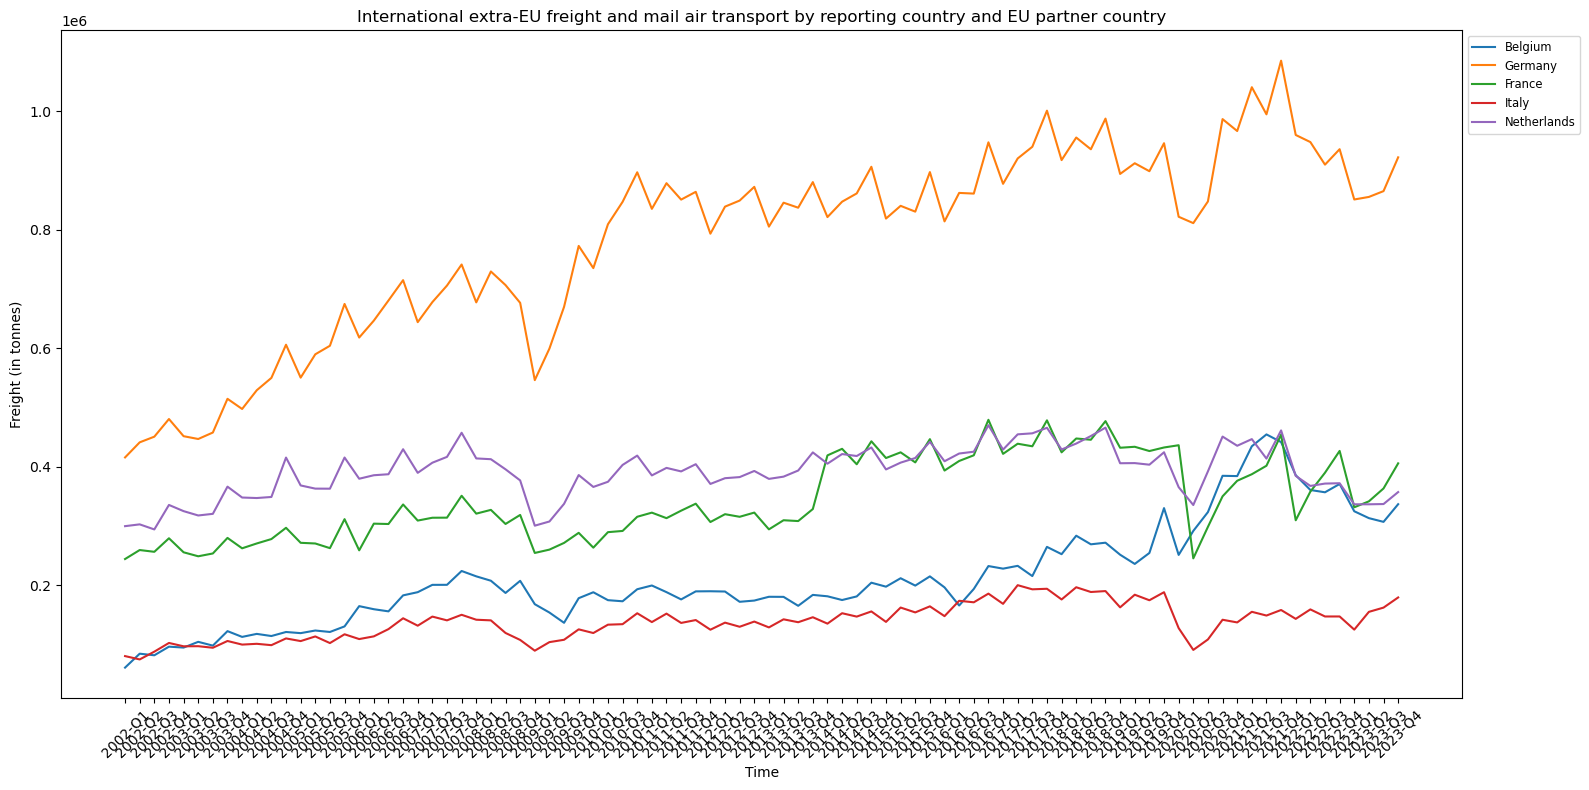

In [20]:
from plotly.offline import init_notebook_mode
import plotly.io as pio
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

init_notebook_mode(connected=True)
pio.renderers.default = "plotly_mimetype+notebook"

file_path = r"data/air/OutraEU_Air_quarterly_5coutries.xlsx"
df_extraeu = pd.read_excel(file_path, sheet_name='Sheet 1', skiprows=9, index_col=0)
df_extraeu.dropna(how='any', inplace=True)

pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)  
df_extraeu.fillna(0, inplace=True)  
x = df_extraeu.columns
y_labels = df_extraeu.index


fig, ax = plt.subplots(figsize=(16, 8))


for country in y_labels:
    y_values = df_extraeu.loc[country].values
    ax.plot(x, y_values, label=country)


ax.set_title("International extra-EU freight and mail air transport by reporting country and EU partner country")
ax.set_xlabel("Time")
ax.set_ylabel("Freight (in tonnes)")


plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


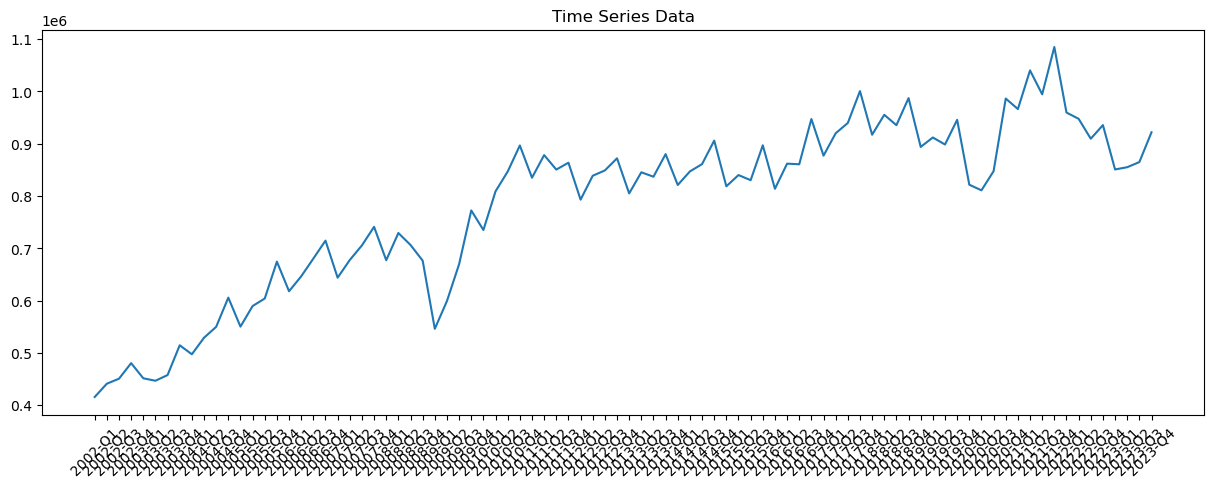

In [24]:
time_series = df_extraeu.T.loc[:, 'Germany'] # Germany for example
plt.figure(figsize=(15, 5))
plt.plot(time_series)
plt.title('Time Series Data')
plt.xticks(rotation=45)
plt.show()

In [79]:
# ADF Test to Check for model assumption: Stationarity
from statsmodels.tsa.stattools import adfuller

pre_pandemic_data = time_series[time_series.index < '2020-Q1']
post_pandemic_data = time_series[time_series.index >= '2019-Q4']
# Perform Augmented Dickey-Fuller Test
result = adfuller(pre_pandemic_data.dropna())  # Ensure no NaN values
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# ADF Statistic: -2.099; p-value: 0.244; fail to reject the null hypothesis, at least one unit root
result = adfuller(pre_pandemic_data.diff().dropna())  # Ensure no NaN values
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# ADF Statistic: -3.687; p-value: 0.0001; reject the null hypothesis, no unit root
pre_pandemic_data_array = np.asarray(pre_pandemic_data, dtype = float)
# Define ARIMA model
# Define ARIMA model
model_ns = ARIMA(pre_pandemic_data_array, order=(5, 1, 2))  # Replace (p, d, q) with the chosen values
model_s = ARIMA(pre_pandemic_data_array, order=(3, 1, 2), seasonal_order=(1,1,1,4))  # Replace (p, d, q) with the chosen values

# Fit the model
model_fit_ns = model_ns.fit()
model_fit_s = model_s.fit()
# Print the model summary
print(model_fit_s.summary())

ADF Statistic: -2.0995686205621986
p-value: 0.2446880967203791
ADF Statistic: -3.6873971759066606
p-value: 0.004293957157136176


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   72
Model:             ARIMA(3, 1, 2)x(1, 1, [1], 4)   Log Likelihood                -781.731
Date:                           Sun, 27 Oct 2024   AIC                           1579.462
Time:                                   22:49:56   BIC                           1597.099
Sample:                                        0   HQIC                          1586.441
                                            - 72                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2065      0.267      0.774      0.439      -0.317       0.730
ar.L2          0.6002      0.331      1.814

In [81]:
forecast_ns = model_fit_ns.forecast(steps=16)
forecast_ns = np.insert(forecast_ns, 0, pre_pandemic_data_array[-1])

forecast_s = model_fit_s.forecast(steps=16)
forecast_s = np.insert(forecast_s, 0, pre_pandemic_data_array[-1])

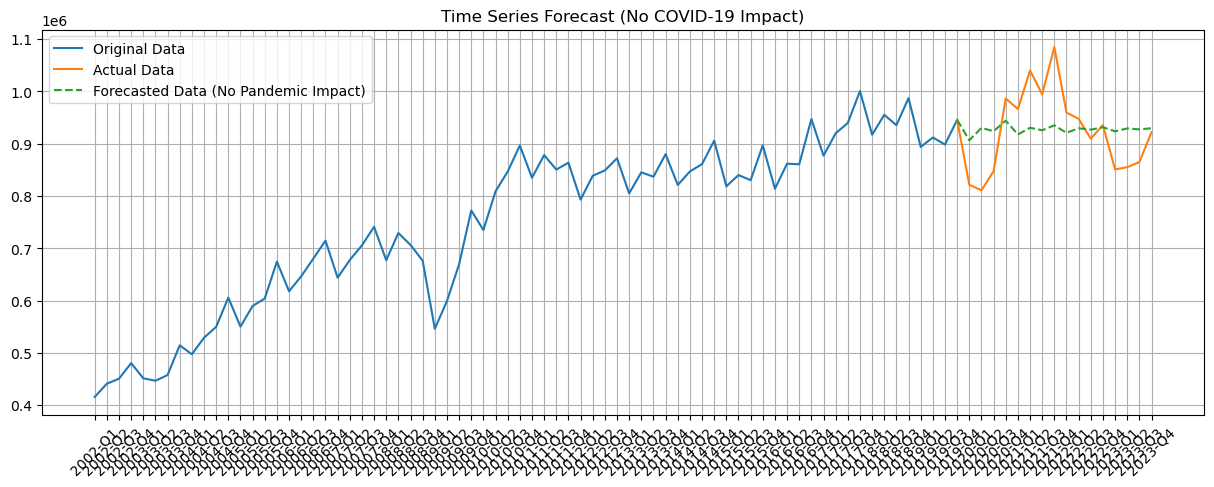

In [72]:
# Plot pre-pandemic data and the forecasted values
plt.figure(figsize=(15, 5))
plt.plot(pre_pandemic_data, label='Original Data')
plt.plot(time_series.index[time_series.index >= '2019-Q4'], post_pandemic_data, label = 'Actual Data')
plt.plot(time_series.index[time_series.index >= '2019-Q4'], forecast_ns, label='Forecasted Data (No Pandemic Impact)', linestyle='--')
plt.title('Time Series Forecast (No COVID-19 Impact)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

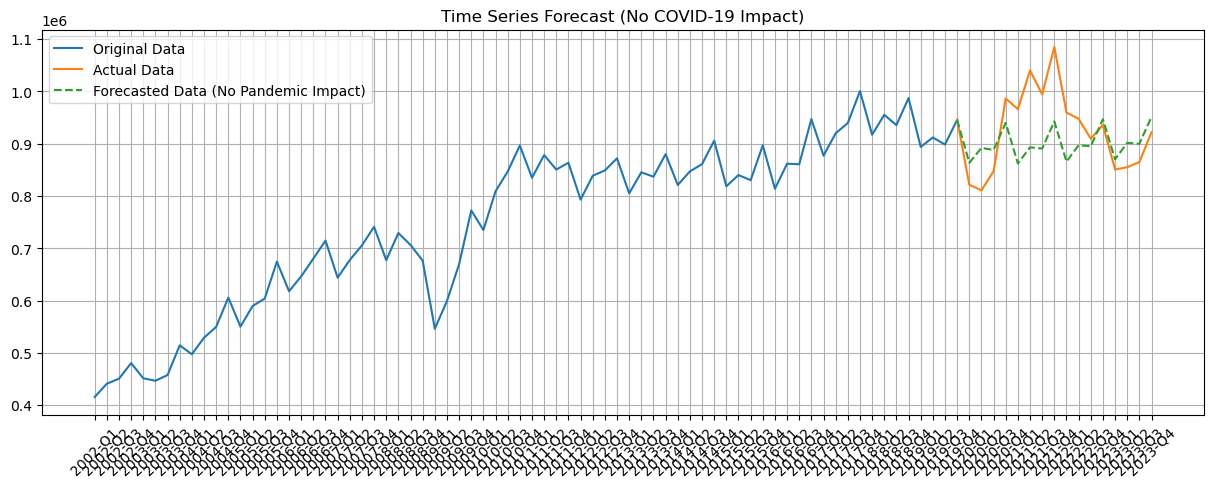

In [83]:
# Plot pre-pandemic data and the forecasted values SEASONAL
plt.figure(figsize=(15, 5))
plt.plot(pre_pandemic_data, label='Original Data')
plt.plot(time_series.index[time_series.index >= '2019-Q4'], post_pandemic_data, label = 'Actual Data')
plt.plot(time_series.index[time_series.index >= '2019-Q4'], forecast_s, label='Forecasted Data (No Pandemic Impact)', linestyle='--')
plt.title('Time Series Forecast (No COVID-19 Impact)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()